<a id="adversarial"></a>
## ML Project - First Model Convolutional GAN on MNIST DATASET

In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
batch_size = 32

# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [5]:
# Architecture simple de Discriminator, provenant de: https://www.tensorflow.org/tutorials/generative/dcgan
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
                   
            nn.Flatten(),
            nn.Linear(7*7*128, 1),
            # nn.Sigmoid()  # Pas besoin si utilisation de nn.BCEWithLogitsLoss(), sinon nn.Sigmoid nécessaire
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)
        output = self.model(x)
        return output

In [6]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=1, bias=True)
  )
)


In [7]:
# Architecture simple de Generator, provenant de: https://www.tensorflow.org/tutorials/generative/dcgan
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
          nn.Linear(100, 7*7*256, bias=False),
          nn.BatchNorm1d(7*7*256),
          nn.LeakyReLU(0.2)
        )
        self.model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh() # Tanh utile car les images du dataset sont normalisées entre [-1 ; 1].
        )

    def forward(self, x):
        output = self.fc(x)
        output = output.view(-1, 256, 7, 7)
        output = self.model(output)
        # output = output.view(-1, 1, 28, 28)
        return output

In [8]:
generator = Generator().to(device)
print(generator)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [9]:
lr = 1e-4
num_epochs = 50
loss_function = nn.BCEWithLogitsLoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)

In [11]:
def train(train_loader, num_epochs, discriminator, generator, optimizer_generator, optimizer_discriminator, checkpoint_path):

  if os.path.isfile(checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    discriminator.load_state_dict(ckpt['discriminator'])
    generator.load_state_dict(ckpt['generator'])

    optimizer_discriminator.load_state_dict(ckpt['optimizer_disc'])
    optimizer_generator.load_state_dict(ckpt['optimizer_gen'])

    start_epoch = ckpt['epoch']
  
  else:
    start_epoch = 0


  for epoch in range(start_epoch, start_epoch + num_epochs):
      for n, (real_samples, mnist_labels) in enumerate(train_loader):
          ##############################
          ## update the discriminator
          ##############################

          batch_size = real_samples.size(0)
          noise = torch.randn((batch_size, 100))
          noise = noise.to(device)
          real_samples = real_samples.to(device)
          
          # zero the parameter gradients
          optimizer_discriminator.zero_grad()
          
          # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
          fake_samples = generator(noise)
          
          # forward du discriminator
          disc_real_output = discriminator(real_samples)
          disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas besoin d'avoir accès au gradient du generateur
          
          # calculate the loss for the discriminator
          loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
          
          # calculate the gradient for the discriminator
          loss_discriminator.backward()  
          
          # update the discriminator first
          optimizer_discriminator.step()
          
          ##############################
          ## update the Generator
          ##############################
          
          # zero the parameter gradients
          optimizer_generator.zero_grad()

          # forward du discriminator
          # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
          disc_fake_output = discriminator(fake_samples)
          
          # calculate the loss for the generator
          loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
          
          # calculate the gradient for the discriminator
          loss_generator.backward() 
          
          # update the generator
          optimizer_generator.step()

          # Show loss
          if n == batch_size - 1:
              print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
              print(f"Epoch: {epoch} Loss G.: {loss_generator}")
              
              # Ajout du suivi de loss dans tensorboard afin d'avoir accès aux graphes de loss post-training 
              writer.add_scalar("Loss/Discriminator_train", loss_discriminator, epoch)
              writer.add_scalar("Loss/Generator_train", loss_generator, epoch)
              writer.flush()
              
              latent_space_samples = torch.randn(batch_size, 100).to(device=device)
              generated_samples = generator(latent_space_samples)
              generated_samples = generated_samples.cpu().detach()

              # Plot de figure pendant l'entrainement, permet de vérifier le bon entrainement du GAN
              figure = plt.figure()
              for i in range(4):
                  ax = plt.subplot(1, 4, i+1)
                  img = plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                  plt.xticks([])
                  plt.yticks([])
              plt.tight_layout()
              plt.show()
              
              # Ajout de la figure dans tensorboard
              writer.add_figure('4_mnist_images', figure, epoch)
              writer.flush()

              # Save checkpoint (to prevent training problem)
              checkpoint = {
                  'epoch': epoch + 1,
                  'generator': generator.state_dict(),
                  'discriminator': discriminator.state_dict(),
                  'optimizer_gen': optimizer_generator.state_dict(),
                  'optimizer_disc': optimizer_discriminator.state_dict()
              }
              torch.save(checkpoint, checkpoint_path)

In [123]:
writer = SummaryWriter('runs/mnist_conv_gan_exp1')

Epoch: 50 Loss D.: 0.6193042397499084
Epoch: 50 Loss G.: 0.9461497068405151


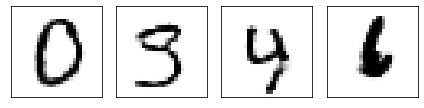

Epoch: 51 Loss D.: 0.7005248069763184
Epoch: 51 Loss G.: 0.792292594909668


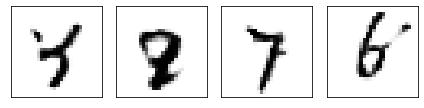

Epoch: 52 Loss D.: 0.6888904571533203
Epoch: 52 Loss G.: 0.812197208404541


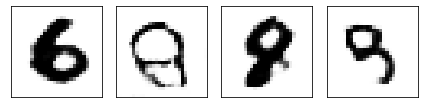

Epoch: 53 Loss D.: 0.6718275547027588
Epoch: 53 Loss G.: 0.7801613807678223


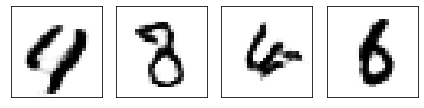

Epoch: 54 Loss D.: 0.6164295673370361
Epoch: 54 Loss G.: 1.0783478021621704


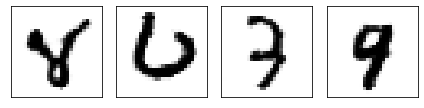

Epoch: 55 Loss D.: 0.5591234564781189
Epoch: 55 Loss G.: 0.847262442111969


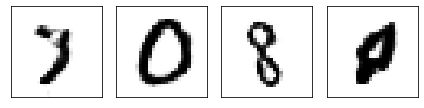

Epoch: 56 Loss D.: 0.6075150966644287
Epoch: 56 Loss G.: 0.987801194190979


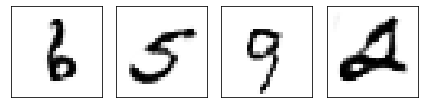

Epoch: 57 Loss D.: 0.5856155157089233
Epoch: 57 Loss G.: 0.8320395946502686


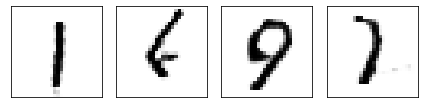

Epoch: 58 Loss D.: 0.6445206999778748
Epoch: 58 Loss G.: 0.8355653285980225


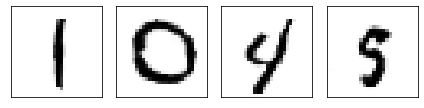

Epoch: 59 Loss D.: 0.7159572839736938
Epoch: 59 Loss G.: 0.7969646453857422


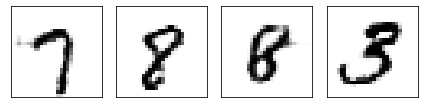

Epoch: 60 Loss D.: 0.5738997459411621
Epoch: 60 Loss G.: 0.8525471687316895


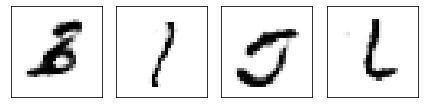

Epoch: 61 Loss D.: 0.7489821314811707
Epoch: 61 Loss G.: 0.8534746170043945


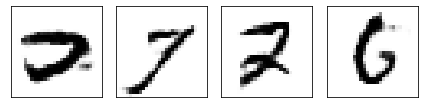

Epoch: 62 Loss D.: 0.584466814994812
Epoch: 62 Loss G.: 1.0553114414215088


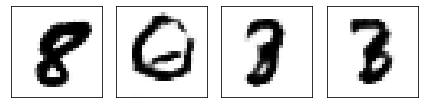

Epoch: 63 Loss D.: 0.649209201335907
Epoch: 63 Loss G.: 0.8230176568031311


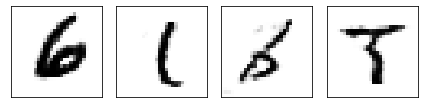

Epoch: 64 Loss D.: 0.6342525482177734
Epoch: 64 Loss G.: 0.9726533889770508


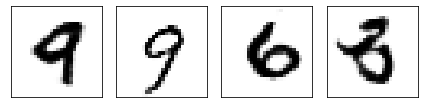

Epoch: 65 Loss D.: 0.641110897064209
Epoch: 65 Loss G.: 0.8764910101890564


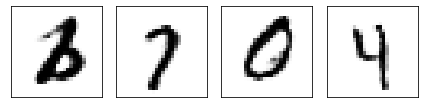

Epoch: 66 Loss D.: 0.6505747437477112
Epoch: 66 Loss G.: 0.9113601446151733


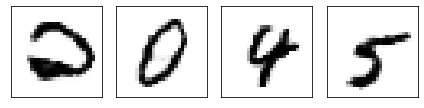

Epoch: 67 Loss D.: 0.6516699194908142
Epoch: 67 Loss G.: 0.9499831795692444


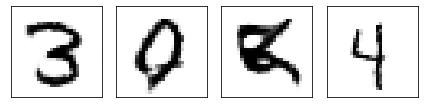

Epoch: 68 Loss D.: 0.6553939580917358
Epoch: 68 Loss G.: 0.802091121673584


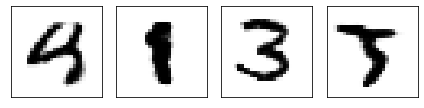

Epoch: 69 Loss D.: 0.5399070978164673
Epoch: 69 Loss G.: 0.9198806285858154


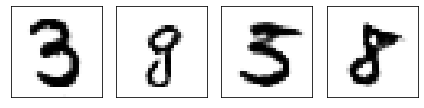

Epoch: 70 Loss D.: 0.5572145581245422
Epoch: 70 Loss G.: 0.9885897636413574


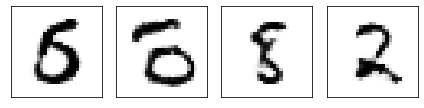

Epoch: 71 Loss D.: 0.6349506378173828
Epoch: 71 Loss G.: 0.8766608238220215


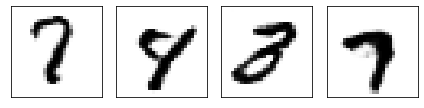

Epoch: 72 Loss D.: 0.701248288154602
Epoch: 72 Loss G.: 0.9477941989898682


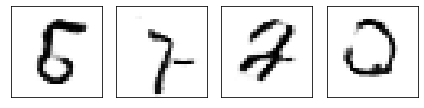

Epoch: 73 Loss D.: 0.6833851337432861
Epoch: 73 Loss G.: 0.891956090927124


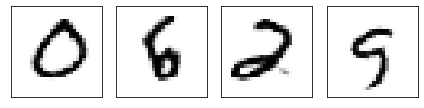

Epoch: 74 Loss D.: 0.6331773400306702
Epoch: 74 Loss G.: 0.8054008483886719


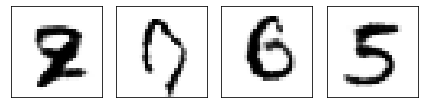

Epoch: 75 Loss D.: 0.6330108642578125
Epoch: 75 Loss G.: 0.9413920044898987


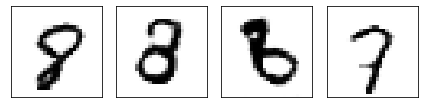

Epoch: 76 Loss D.: 0.7298080921173096
Epoch: 76 Loss G.: 0.8827659487724304


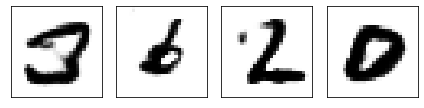

Epoch: 77 Loss D.: 0.6542587876319885
Epoch: 77 Loss G.: 0.9967488050460815


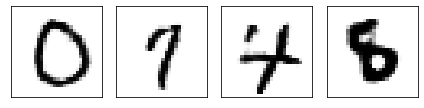

Epoch: 78 Loss D.: 0.6422520279884338
Epoch: 78 Loss G.: 0.7415534853935242


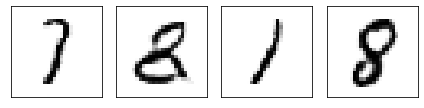

Epoch: 79 Loss D.: 0.6309831738471985
Epoch: 79 Loss G.: 0.774696946144104


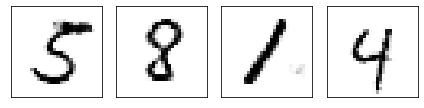

Epoch: 80 Loss D.: 0.552192211151123
Epoch: 80 Loss G.: 0.7502424716949463


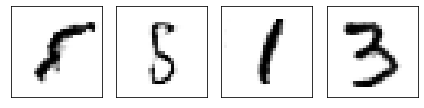

Epoch: 81 Loss D.: 0.6542412042617798
Epoch: 81 Loss G.: 0.8709133267402649


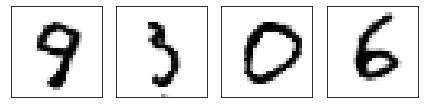

Epoch: 82 Loss D.: 0.659702718257904
Epoch: 82 Loss G.: 0.8402546644210815


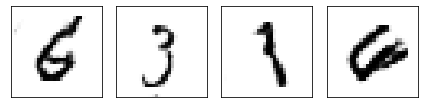

Epoch: 83 Loss D.: 0.6457019448280334
Epoch: 83 Loss G.: 0.7938591241836548


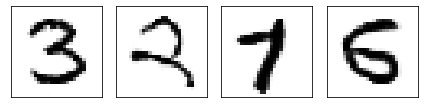

Epoch: 84 Loss D.: 0.6248687505722046
Epoch: 84 Loss G.: 0.8052923083305359


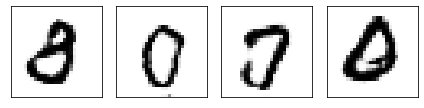

Epoch: 85 Loss D.: 0.5989007353782654
Epoch: 85 Loss G.: 0.8330205678939819


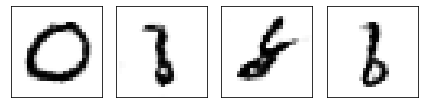

Epoch: 86 Loss D.: 0.6547890901565552
Epoch: 86 Loss G.: 0.8475001454353333


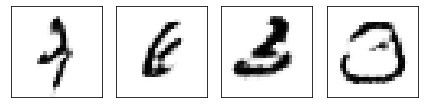

Epoch: 87 Loss D.: 0.5588634014129639
Epoch: 87 Loss G.: 0.8266149759292603


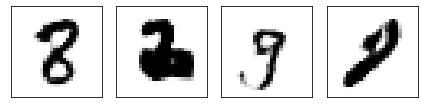

Epoch: 88 Loss D.: 0.6431494951248169
Epoch: 88 Loss G.: 0.7133736610412598


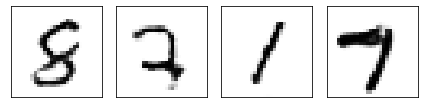

Epoch: 89 Loss D.: 0.6336387395858765
Epoch: 89 Loss G.: 0.9328673481941223


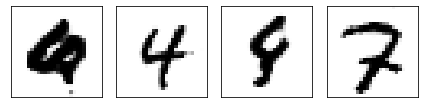

Epoch: 90 Loss D.: 0.6581873297691345
Epoch: 90 Loss G.: 0.8648340702056885


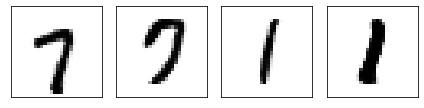

Epoch: 91 Loss D.: 0.6797767281532288
Epoch: 91 Loss G.: 0.8981902599334717


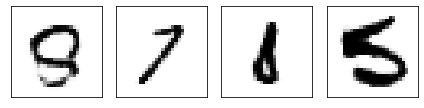

Epoch: 92 Loss D.: 0.6776503324508667
Epoch: 92 Loss G.: 0.8021773099899292


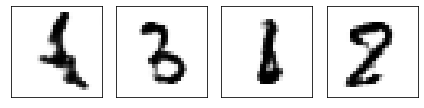

Epoch: 93 Loss D.: 0.6123895645141602
Epoch: 93 Loss G.: 0.8289949893951416


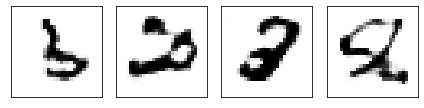

Epoch: 94 Loss D.: 0.6502307057380676
Epoch: 94 Loss G.: 0.9462778568267822


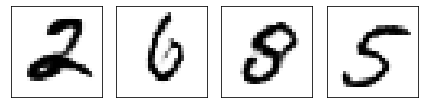

Epoch: 95 Loss D.: 0.6711670160293579
Epoch: 95 Loss G.: 0.7845625877380371


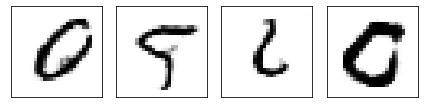

Epoch: 96 Loss D.: 0.6502698659896851
Epoch: 96 Loss G.: 1.0072505474090576


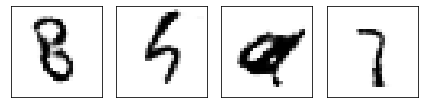

Epoch: 97 Loss D.: 0.6101219654083252
Epoch: 97 Loss G.: 0.9721565246582031


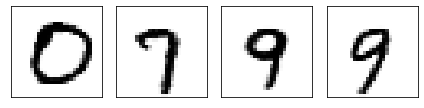

Epoch: 98 Loss D.: 0.6217867136001587
Epoch: 98 Loss G.: 0.8180872201919556


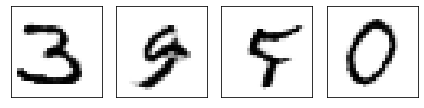

Epoch: 99 Loss D.: 0.6820248961448669
Epoch: 99 Loss G.: 0.8338326811790466


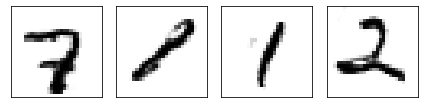

In [124]:
# Lance la boucle de training, si un checkpoint est trouvé, alors continue le training, sinon en démarre un nouveau
train(train_loader, num_epochs, discriminator, generator, optimizer_generator, optimizer_discriminator, checkpoint_path='../trained_model/conv_gan_ckpt_100epo.pt')